<a href="https://colab.research.google.com/github/MeenTers/KKU_data_mining/blob/master/MVCNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Function

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from PIL import Image
import cv2
import csv
import copy

import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score

from torchvision import models
import torchvision.transforms as transforms


import pickle

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = '/content/drive/MyDrive/Project_si/Class'

# Image Processing Parameters 
BLUR = 21
CANNY_THRESH_1 = 25
CANNY_THRESH_2 = 150
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10

In [4]:
def preprocess(filename):
    img = cv2.imread(filename)
    imgResized = cv2.resize(img, (0, 0), fx = 0.1, fy = 0.1)
    gray = cv2.cvtColor(imgResized, cv2.COLOR_BGR2GRAY)

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)

    #-- Create final image ---------------------------------------------------------------
    imgResized[mask <= 100] = 0
    return imgResized

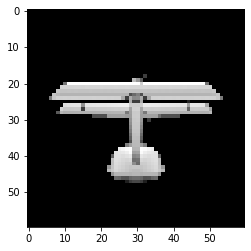

In [5]:
filename = '/content/drive/MyDrive/Project_si/Class/airplane/train/airplane_0001.off/airplane_0001.0.png'
img = preprocess(filename)

plt.imshow(img);

In [10]:
# Preprocess all images and Save them to a new directory `processed`

filenames = glob.glob(os.path.join(data_dir, '*.JPG')) # list all image file names in the data folder
proc_data_dir = '/content/drive/MyDrive/Project_si/Class/airplane/train'

for fname in filenames:
    img_name = os.path.basename(fname)
    img = preprocess(fname)
    cv2.imwrite(os.path.join(proc_data_dir, os.path.splitext(img_name)[0] + '_processed.png'), img)

In [12]:
# Function for visualizing a Car Plug (with all its 8 images)

def show_plug(plug_name, data_dir, preprocess=None):
    # Read Images
    plug_fnames = glob.glob(os.path.join(data_dir, f'{plug_name}*.JPG'))
    if preprocess:
        plug_images = [preprocess(plug_fname) for plug_fname in plug_fnames]
    else:
        plug_images = [cv2.cvtColor(cv2.imread(plug_fname), cv2.COLOR_BGR2RGB) for plug_fname in plug_fnames]
    # Visualize Images
    plt.figure(figsize=(18,8))
    for i in range(len(plug_images)):
        plt.subplot(2, 4, i+1)
        plt.imshow(plug_images[i])
        plt.title(os.path.basename(plug_fnames[i]))
        plt.xticks([])
        plt.yticks([])
        
    plt.suptitle(f'Item: {plug_name}', size=20)

In [13]:
# Example Visualization

plug_name = 'ener1'
show_plug(plug_name, data_dir)
show_plug(plug_name, data_dir, preprocess=preprocess)

<Figure size 1296x576 with 0 Axes>

<Figure size 1296x576 with 0 Axes>